In [ ]:
import torch
import torchvision
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision import transforms
import numpy as np
import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Show function
def show(tensor,num=25):
  data = tensor.detach().cpu()
  grid = make_grid(data[:num],nrow=5).permute(1,2,0).numpy()
  plt.imshow(grid.clip(0,1))
  plt.show()


# Hyperparams :
n_epochs = 10000
batch_size = 128
lr = 1e-4
z_dim = 200

# Image size:
size = (256,256)
size1 , size2 = size

# Params:
cur_step = 0
crit_cycles = 5
gen_losses = []
crit_losses = []
show_step = 35
save_step = 35

### Downloading the database

In [ ]:
data_ds = torchvision.datasets.Flowers102(root="data",
                                             split="train",
                                             download=True,
                                             transform=transforms.ToTensor(),
                                             target_transform=None)

data_transforms = transforms.Compose([
    transforms.Resize((size1,size2)),
    transforms.ToTensor(),
])

data_ds.transform = data_transforms
print(len(data_ds))

1020


In [ ]:
from torch.utils.data import DataLoader

data_dl = DataLoader(data_ds,
                      batch_size=batch_size,
                      pin_memory=True,
                      num_workers=2,
                      shuffle=True)

In [ ]:
labels_name=[ 'pink primrose',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english marigold',
 'tiger lily',
 'moon orchid',
 'bird of paradise',
 'monkshood',
 'globe thistle',
 'snapdragon',
 "colt's foot",
 'king protea',
 'spear thistle',
 'yellow iris',
 'globe-flower',
 'purple coneflower',
 'peruvian lily',
 'balloon flower',
 'giant white arum lily',
 'fire lily',
 'pincushion flower',
 'fritillary',
 'red ginger',
 'grape hyacinth',
 'corn poppy',
 'prince of wales feathers',
 'stemless gentian',
 'artichoke',
 'sweet william',
 'carnation',
 'garden phlox',
 'love in the mist',
 'mexican aster',
 'alpine sea holly',
 'ruby-lipped cattleya',
 'cape flower',
 'great masterwort',
 'siam tulip',
 'lenten rose',
 'barbeton daisy',
 'daffodil',
 'sword lily',
 'poinsettia',
 'bolero deep blue',
 'wallflower',
 'marigold',
 'buttercup',
 'oxeye daisy',
 'common dandelion',
 'petunia',
 'wild pansy',
 'primula',
 'sunflower',
 'pelargonium',
 'bishop of llandaff',
 'gaura',
 'geranium',
 'orange dahlia',
 'pink-yellow dahlia?',
 'cautleya spicata',
 'japanese anemone',
 'black-eyed susan',
 'silverbush',
 'californian poppy',
 'osteospermum',
 'spring crocus',
 'bearded iris',
 'windflower',
 'tree poppy',
 'gazania',
 'azalea',
 'water lily',
 'rose',
 'thorn apple',
 'morning glory',
 'passion flower',
 'lotus',
 'toad lily',
 'anthurium',
 'frangipani',
 'clematis',
 'hibiscus',
 'columbine',
 'desert-rose',
 'tree mallow',
 'magnolia',
 'cyclamen ',
 'watercress',
 'canna lily',
 'hippeastrum ',
 'bee balm',
 'ball moss',
 'foxglove',
 'bougainvillea',
 'camellia',
 'mallow',
 'mexican petunia',
 'bromelia',
 'blanket flower',
 'trumpet creeper',
 'blackberry lily']


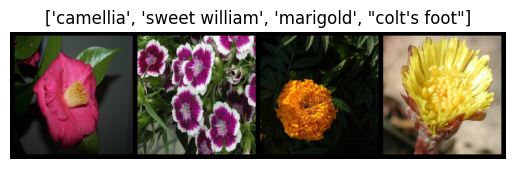

In [ ]:
# Visualizing some images :3

def plot(img,y):
  npimg=img.numpy()
  npimg_t=np.transpose(npimg,(1,2,0))
  plt.imshow(npimg_t,)
  plt.title(y)
  plt.axis(False)

grid_size=4
random_idx = np.random.randint(0,len(data_ds),grid_size)
x_grid_train = [data_ds[i][0] for i in random_idx]
y_grid_train = [data_ds[i][1] for i in random_idx]

for i in range(grid_size):
  y_grid_train[i]=labels_name[y_grid_train[i]]

x_grid_train = torchvision.utils.make_grid(x_grid_train,nrow=4,padding=10).cpu()

plot(x_grid_train,y_grid_train)

In [ ]:

def GenBlock(in_layers,out_layers,kernel=4,stride=2,padding=1):
  # Default is for /2 sampling
  return nn.Sequential(
      nn.ConvTranspose2d(in_layers,out_layers,kernel,stride,padding),
      nn.BatchNorm2d(out_layers),
      nn.ReLU(inplace=True),
      )


# new width and height : (n-1)*stride - 2*padding +ks
class Generator(nn.Module):
  def __init__(self,z_dim,d_dim=16):
    super().__init__()

    self.z_dim = z_dim
    self.gen = nn.Sequential(
        GenBlock(z_dim,d_dim * 64,4,1,0),
        # 200 x 1 x 1 -> 1024 x 4 x 4
        GenBlock(d_dim*64,d_dim*32),
        # 1024 x 4 x 4 -> 512 x 8 x 8
        GenBlock(d_dim*32,d_dim*16),
        # 512 x 8 x 8 -> 256 x 16 x 16
        GenBlock(d_dim*16,d_dim*8),
        # 256 x 16 x 16 -> 128 x 32 x 32
        GenBlock(d_dim*8,d_dim*4),
        # 128 x 32 x 32 -> 64 x 64 x 64
        GenBlock(d_dim*4,d_dim*2),
        # 64 x 64 x 64 -> 32 x 128 x 128
        GenBlock(d_dim*2,3),
        # 16 x 256 x 256
        nn.Tanh(), # from -1 to 1
    )

  def forward(self,noise):
    x = noise.view(len(noise),self.z_dim,1,1) # 128 x 200 x 1 x 1
    return self.gen(x)

def gen_noise(num,z_dim,device=device):
  return torch.randn(num,z_dim,device=device)

In [ ]:

## Critic model
def CritBlock(in_layers,out_layers,kernel=4,stride=2,padding=1):
  return nn.Sequential(
      nn.Conv2d(in_layers,out_layers,kernel,stride,padding),
      nn.InstanceNorm2d(out_layers),
      nn.LeakyReLU(0.2),
  )

# (n+2*pad-ks)//stride + 1
class Critic(nn.Module):
  def __init__(self,d_dim=16):
    super().__init__()

    #256 x 256
    self.critic = nn.Sequential(
        CritBlock(3,d_dim), # 128
        CritBlock(d_dim,d_dim*2), # 64
        CritBlock(d_dim*2,d_dim*4), # 32
        CritBlock(d_dim*4,d_dim*8), # 16
        CritBlock(d_dim*8,d_dim*16), # 8
        CritBlock(d_dim*16,d_dim*32), # 4

        nn.Conv2d(d_dim*32,1,4,1,0) # 1
    )

  def forward(self,image):
    #128 x 3 x 256 x 256
    crit_pred = self.critic(image) #128 x 1 x 1 x1
    crit_pred = crit_pred.view(len(crit_pred),-1)

    return crit_pred

In [ ]:
# Models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

# Optimizers
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr,betas=(0.5,0.9))
crit_opt = torch.optim.Adam(crit.parameters(),lr=lr,betas=(0.5,0.9))

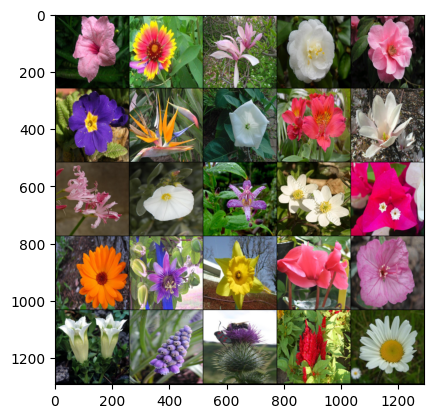

In [ ]:
x,_ = next(iter(data_dl))
show(x)

In [ ]:
for x,y in data_dl:
  print(x.shape)
  print(y.shape)
  break;

torch.Size([128, 3, 256, 256])
torch.Size([128])


In [ ]:
## Gradient Penality

def get_gp(real,fake,crit,alpha,gamma=10):
  mix_images = real * alpha + (1-alpha)*fake
  mix_scores = crit(mix_images)

  gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs = torch.ones_like(mix_scores),
      retain_graph = True,
      create_graph = True,
  )[0]  # 128 x 3 x 128 x 128

  gradient = gradient.view(len(gradient),-1) # 128 x 49512
  gradient_norm = gradient.norm(2,dim=1)

  gp = ((gradient_norm-1)**2).mean()

  return gp

In [ ]:
## Save and load checkpoints

!mkdir models
root = "./models/"

def save_checkpoint(name):
  torch.save({
      'epoch' : epoch,
      'model_state_dict' : gen.state_dict(),
      'optimizer_state_dict' : gen_opt.state_dict()
              },
             f"{root}G-{name}.pkl" )

  torch.save({
      'epoch' : epoch,
      'model_state_dict' : crit.state_dict(),
      'optimizer_state_dict' : crit_opt.state_dict()
              },
             f"{root}C-{name}.pkl" )

  print("Saved checkpoint")

def load_checkpoint(name):
  checkpoint = torch.load(f"{root}G-{name}.pkl")
  gen.load_state_dict(checkpoint['model_state_dict'])
  gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  checkpoint = torch.load(f"{root}C-{name}.pkl")
  crit.load_state_dict(checkpoint['model_state_dict'])
  crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  print("Loaded checkpoint")

mkdir: cannot create directory ‘models’: File exists


In [ ]:
epoch=1
save_checkpoint("test")
load_checkpoint("test")

Saved checkpoint
Loaded checkpoint


Saved checkpoint
Loaded checkpoint
Loaded checkpoint
Loaded checkpoint
Loaded checkpoint


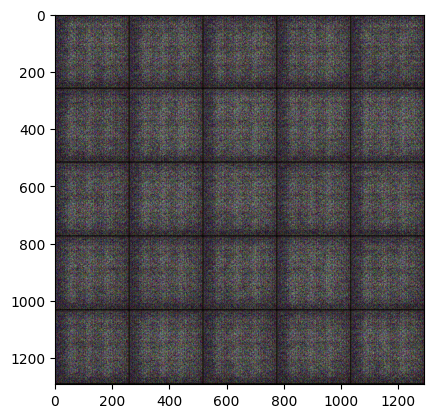

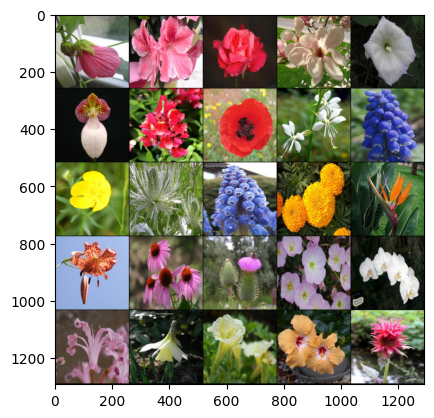

Epoch:5 | Step: 36
Gen Loss: 29.84952163696289 | Crit Loss: -38.40113830566406
Loaded checkpoint
Loaded checkpoint
Loaded checkpoint
Loaded checkpoint


KeyboardInterrupt: 

In [ ]:
## Training Loop

best_loss = 1000000

for epoch in range(n_epochs):
  for real,_ in data_dl:
    cur_bs = len(real)
    real = real.to(device)

    # Critic
    mean_critic_loss = 0
    for _ in range(crit_cycles):
      crit_opt.zero_grad()

      noise = gen_noise(cur_bs,z_dim)
      fake = gen(noise)
      crit_fake_pred = crit(fake)
      crit_real_pred = crit(real)

      alpha = torch.rand(len(real),1,1,1,device=device,requires_grad=True)
      gp = get_gp(real,fake.detach(),crit,alpha)
      crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

      mean_critic_loss += crit_loss.item()/crit_cycles

      crit_loss.backward()
      crit_opt.step()

      crit_losses +=[mean_critic_loss]


    # Generator
    gen_opt.zero_grad()
    noise = gen_noise(cur_bs,z_dim)
    fake = gen(noise)
    crit_fake_pred = crit(fake)

    gen_loss = -crit_fake_pred.mean()
    gen_loss.backward()
    gen_opt.step()

    gen_losses += [gen_loss.item()]

    # Stats
    if (cur_step % show_step ==0 and cur_step>0):
      show(fake)
      show(real)

      print(f"Epoch:{epoch+1} | Step: {cur_step+1}\r")
      print(f"Gen Loss: {gen_loss} | Crit Loss: {crit_loss}")

    cur_step+=1


  if(gen_loss < best_loss):
    best_loss = gen_loss
    save_checkpoint("best_loss")

  load_checkpoint("best_loss")

In [ ]:
torch.cuda.empty_cache()
noise = gen_noise(cur_bs,z_dim)
fake = gen(noise)
show(fake)
print(cur_step)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from torchsummary import summary

summary(crit,input_size=(3,256,256))

In [ ]:
summary(gen,input_size=(200,1,1))